In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from collections import OrderedDict

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prospect.utils.obsutils import fix_obs
import pyDOE2

from agnfinder.prospector import main, cpz_builders, visualise
from agnfinder import simulation_utils

In [3]:
os.chdir('/home/mike/repos/agnfinder')

In [4]:
!pwd

/home/mike/repos/agnfinder


# Setup

In [5]:
galaxy_index = 1
galaxy = main.load_galaxy(galaxy_index)
redshift = galaxy['redshift']

In [6]:
agn_mass = True
agn_eb_v = True
agn_torus_mass = True
igm_absorbtion = True
emulate_ssp = True

In [7]:
run_params, obs, model, sps = main.construct_problem(galaxy, redshift=redshift, agn_mass=agn_mass, agn_eb_v=agn_eb_v, agn_torus_mass=agn_torus_mass, igm_absorbtion=igm_absorbtion, emulate_ssp=emulate_ssp)

 /media/mike/Windows/linux_cache/py36/lib/python3.6/site-packages/sklearn/base.py:253: UserWarning:Trying to unpickle estimator PCA from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.


In [8]:
sps

In [9]:
model

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)
  agn_mass: <class 'prospect.models.priors.LogUniform'>(mini=1e-07,maxi=15)
  agn_eb_v: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=0.5)
  agn_torus_mass: <class 'prospect.models.priors.LogUniform'>(mini=1e-07,maxi=15)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: 0.155 
  logzsol: 0.0 
  sfh: 4 
  imf_type: 2 
  dust_type: 2 
  add_dust_emission: True 
  duste_umin: 1.0 
  duste_qpah: 4.0 
  duste_gamma: 0.001 
  add_igm_absorption: True 
  igm_factor: 1.0 

And model should include agn_mass and agn_eb_v

In [10]:
model.free_params

['mass', 'dust2', 'tage', 'tau', 'agn_mass', 'agn_eb_v', 'agn_torus_mass']

In [11]:
model.fixed_params

['zred',
 'logzsol',
 'sfh',
 'imf_type',
 'dust_type',
 'add_dust_emission',
 'duste_umin',
 'duste_qpah',
 'duste_gamma',
 'add_igm_absorption',
 'igm_factor']

# Create Parameter Hypercube

In [28]:
# a bit hacky - log* keys will be 10 ** within simulator function below
free_params = OrderedDict({
    'log_mass': [8, 12], 
    'dust2': [0.001, 13.8],
    'tage': [0., 2.],
    'tau': [.1, 30],
    'log_agn_mass': [-7, np.log10(15)],
    'agn_eb_v': [0., 0.5],
    'log_agn_torus_mass': [-7, np.log10(15)]
})
param_dim = len(free_params.keys())

n_samples = 100

In [29]:
hcube = simulation_utils.get_unit_latin_hypercube(param_dim, n_samples)

In [30]:
hcube.shape

(100, 7)

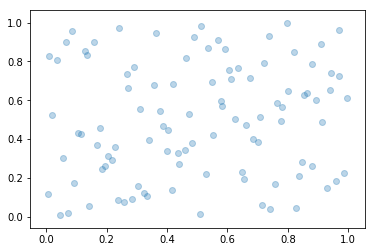

In [31]:
plt.scatter(hcube[:, 0], hcube[:, 1], alpha=0.3)

In [15]:
denormalised_hcube = simulation_utils.denormalise_hypercube(hcube, free_params)

In [16]:
theta_df = pd.DataFrame(denormalised_hcube, columns=free_params.keys())
theta_df.head()

,log_mass,dust2,tage,tau,log_agn_mass,agn_eb_v,log_agn_torus_mass
0,1.374791e+15,8.959729,0.595974,18.550716,1.703113e+17,0.344548,3.040943e+17
1,1.977149e+15,13.726794,1.556750,9.414965,1.524533e+17,0.245928,1.102782e+17
2,2.154861e+15,8.804108,1.630058,18.981914,2.567881e+17,0.360679,2.618598e+17
3,1.562174e+15,9.156391,0.663658,11.137817,9.290079e+16,0.220151,2.261708e+17
4,1.712060e+15,8.868730,0.054694,13.070924,8.099502e+16,0.402856,2.381854e+17


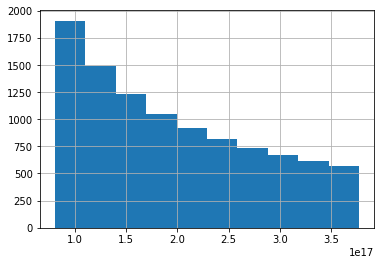

In [17]:
theta_df['log_agn_torus_mass'].hist()

In [18]:
normalised_theta_df = pd.DataFrame(hcube, columns=free_params.keys())
normalised_theta_df.head()

,log_mass,dust2,tage,tau,log_agn_mass,agn_eb_v,log_agn_torus_mass
0,0.161382,0.648303,0.297987,0.520425,0.534850,0.689095,0.148982
1,0.463382,0.993767,0.778375,0.214882,0.606069,0.491856,0.809821
2,0.536541,0.637025,0.815029,0.534847,0.263850,0.721359,0.250662
3,0.266334,0.662555,0.331829,0.272502,0.915061,0.440302,0.348832
4,0.342417,0.641708,0.027347,0.337155,0.997943,0.805711,0.314317


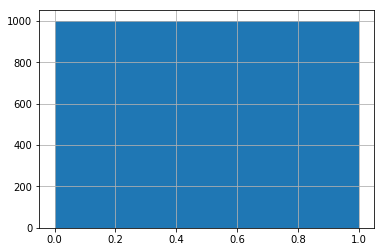

In [19]:
normalised_theta_df['log_agn_torus_mass'].hist()

*Don't modify these!*

# Infer Observations

- Calculate observations with denomalised hypercube (i.e. param space)
- Show LFI hypercube -> observations

In [20]:
model_spectra, model_photometry, spec_wavelengths = visualise.calculate_sed(model, model.theta, obs, sps) 
phot_wavelengths = obs['phot_wave']

Text(0, 0.5, 'Observed Flux')

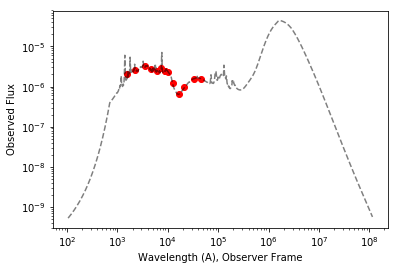

In [21]:
plt.loglog(phot_wavelengths, model_photometry, 'o', color='r')
plt.loglog(spec_wavelengths, model_spectra, 'k--', alpha=0.5)
plt.xlabel('Wavelength (A), Observer Frame')
plt.ylabel('Observed Flux')

In [22]:
def simulator(theta):
    _, model_photometry, _ = visualise.calculate_sed(model, theta, obs, sps)  # via closure
#     phot_wavelengths = obs['phot_wave']  # always the same, as in observer frame
    return model_photometry

In [23]:
model.theta

array([1.e+10, 6.e-01, 1.e+00, 1.e+00, 1.e+00, 1.e-01, 1.e-01])

In [24]:
simulator(theta_df.iloc[0].values)

array([7.92091070e+15, 1.58152430e+15, 2.37415349e+16, 2.55560041e+16,
       3.10783335e+16, 4.09549822e+16, 4.14358272e+16, 1.29559917e+17,
       6.07486425e+16, 3.09084361e+17, 4.86019205e+16, 4.13517784e+16,
       6.22943041e+17, 6.29423396e+17])

In [25]:
normalised_params, photometry = simulation_utils.sample(
    theta_df=theta_df,
    n_samples=n_samples,
    output_dim=14,
    simulator=simulator
)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/media/mike/Windows/linux_cache/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-4c09961f2a70>", line 5, in <module>
    simulator=simulator
  File "/home/mike/repos/agnfinder/agnfinder/simulation_utils.py", line 29, in sample
    Y[n] = simulator(X[n])
  File "<ipython-input-22-825e81dab193>", line 2, in simulator
    _, model_photometry, _ = visualise.calculate_sed(model, theta, obs, sps)  # via closure
  File "/home/mike/repos/agnfinder/agnfinder/prospector/visualise.py", line 70, in calculate_sed
    model_spectra, model_photometry, _ = model.sed(theta, obs=obs, sps=sps)  # call sps.get_spectrum()
  File "/home/mike/repos/prospector/prospect/models/sedmodel.py", line 83, in sed
    **self.params)
  File "/home/mike/repos/prospector/prospect/sources/ssp_basis.py", line 179, in get_spectrum
    wave, spectrum, mfrac = sel

KeyboardInterrupt: 

In [ ]:
for galaxy in photometry[:15]:
    plt.loglog(phot_wavelengths, galaxy, 'o--', alpha=0.5)  # re-using wavelengths from earlier

In [ ]:
simulation_utils.save_samples(
    save_loc='/media/mike/internal/agnfinder/photometry_simulation.hdf5',
    free_params=free_params,
    theta_df=theta_df,
    normalised_theta_df=normalised_theta_df,
    simulated_y=photometry,
    wavelengths=phot_wavelengths
)